In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/A B test 1/cookie_cats.csv')

---

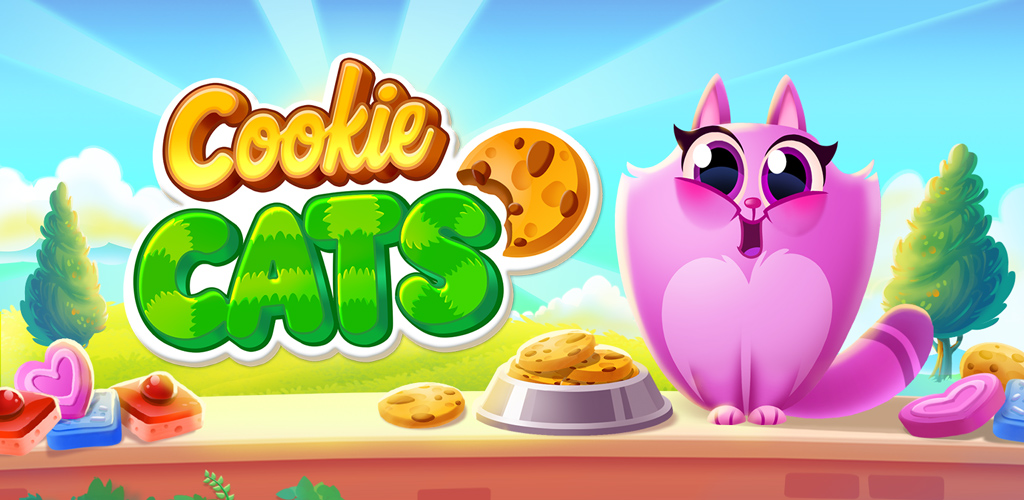

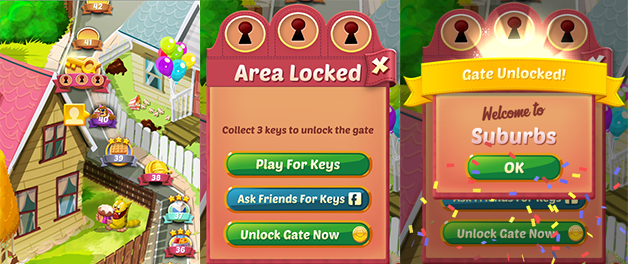

## **Описание игры**

**Cookie Cats** - это мобильная головоломка, разработанная компанией Tactile Entertainment. Это классическая "три в ряд", где игрок должен соединять плитки одного цвета, чтобы очистить доску и выиграть уровень.

По мере прохождения уровней в игре игроки время от времени сталкиваются с воротами, которые заставляют их либо подождать некоторое время, либо совершить покупку внутри приложения, чтобы продолжить. Помимо стимулирования внутриигровых покупок, такие ворота выполняют важную функцию: они принудительно дают игрокам перерыв в игре, что, как предполагается, повышает и продлевает удовольствие от игрового процесса.

Но где именно размещать эти ворота? Изначально первые ворота стояли на уровне 30. В этом проекте мы будем анализировать A/B-тест, в котором первые ворота в игре Cookie Cats были перенесены с уровня 30 на уровень 40. В частности, мы рассмотрим влияние этого изменения на удержание игроков.

---

## **Данные**

In [ ]:
data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [ ]:
print(f'Количество игроков: {data.shape[0]}')
print(f'Количество показателей: {data.shape[1]}')

Количество игроков: 90189
Количество показателей: 5


Данные собраны по 90 189 игрокам, которые установили игру в период проведения A/B-теста. Переменные следующие:

* **userid** — уникальный номер, идентифицирующий каждого игрока.
* **version** — к какой группе был отнесён игрок: контрольной (**gate_30** — ворота на уровне 30) или тестовой (**gate_40** — ворота на уровне 40).
* **sum_gamerounds** — количество игровых раундов, сыгранных игроком в течение первой недели после установки.
* **retention_1** — вернулся ли игрок и играл ли он через 1 день после установки.
* **retention_7** — вернулся ли игрок и играл ли он через 7 дней после установки.

При установке игры каждый игрок случайным образом распределялся либо в группу **gate_30**, либо в группу **gate_40**.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Пропусков нет

---

## **Первичный анализ**

### **1) Число игровых раундов в разрезе экспериментальных групп**

In [ ]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


**Бросается в глаза сильный разброс значений у первого варианта**

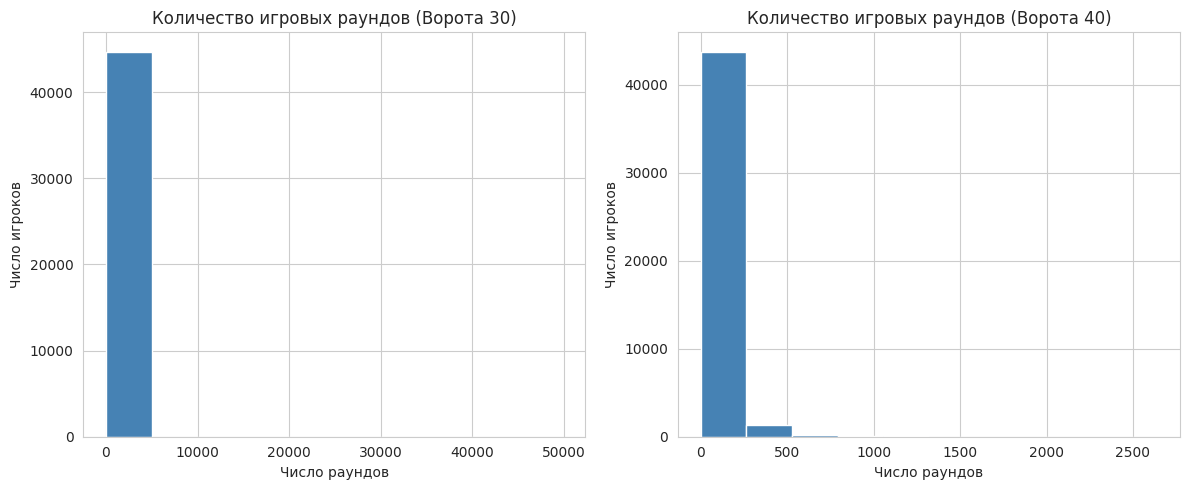

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

data[data.version == "gate_30"].hist(
    column="sum_gamerounds",
    ax=axes[0],
    color="steelblue"
)
axes[0].set_title("Количество игровых раундов (Ворота 30)")
axes[0].set_xlabel("Число раундов")
axes[0].set_ylabel("Число игроков")

data[data.version == "gate_40"].hist(
    column="sum_gamerounds",
    ax=axes[1],
    color="steelblue"
)
axes[1].set_title("Количество игровых раундов (Ворота 40)")
axes[1].set_xlabel("Число раундов")
axes[1].set_ylabel("Число игроков")

plt.tight_layout()
plt.show()

**Шкалы сильно отличаются - у первого варианта есть выбросы**

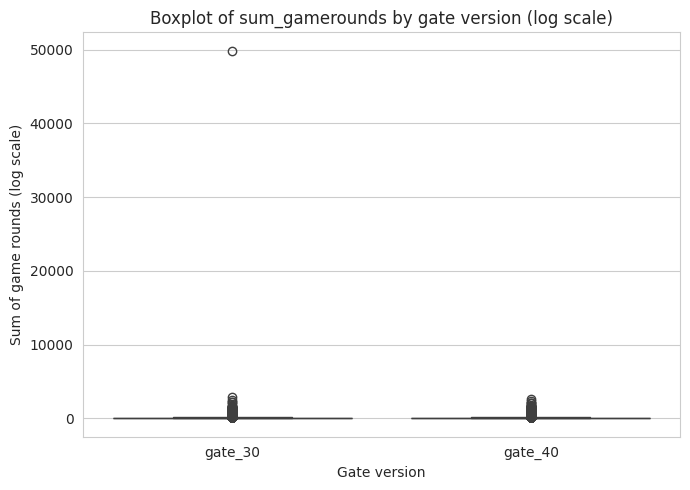

In [ ]:
plt.figure(figsize=(7, 5))

sns.boxplot(
    data=data,
    x="version",
    y="sum_gamerounds",
    showfliers=True
)

plt.title("Boxplot of sum_gamerounds by gate version (log scale)")
plt.xlabel("Gate version")
plt.ylabel("Sum of game rounds (log scale)")

plt.tight_layout()
plt.show()

**Удалим выброс у ворот 30 (Все, что больше 10.000)**

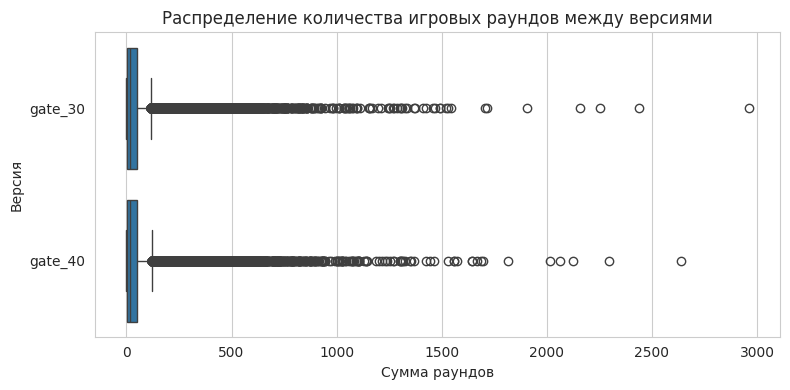

In [ ]:
# фильтруем только Gate 30
mask_gate30 = data["version"] == "gate_30"
data_2 = data[~(mask_gate30 & (data["sum_gamerounds"] > 10000))]

plt.figure(figsize=(8, 4))
sns.boxplot(
    data=data_2,
    y="version",
    x="sum_gamerounds",
    showfliers=True
)

plt.title("Распределение количества игровых раундов между версиями")
plt.ylabel("Версия")
plt.xlabel("Сумма раундов")
plt.tight_layout()
plt.show()


In [ ]:
# базовая сводная статистика
summary = data_2.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

# Игроки с числом сессий > 0
sessions_gt0 = data_2.groupby("version")["sum_gamerounds"].apply(lambda x: (x > 0).sum())

# вставляем после count
summary.insert(1, "sessions_gt0", sessions_gt0)
print(summary)


         count  sessions_gt0  median       mean         std   max
version                                                          
gate_30  44699         42762    17.0  51.342111  102.057598  2961
gate_40  45489         43432    16.0  51.298776  103.294416  2640


In [ ]:
# Задаем интересующие нас квантили (от 0.1 до 1.0)
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

# Расчет распределения для всего датасета
dist_all = data_2['sum_gamerounds'].quantile(quantiles)

# Расчет распределения в разрезе версий (A/B групп)
dist_by_version = data_2.groupby('version')['sum_gamerounds'].quantile(quantiles).unstack()

print("Числовое распределение раундов (квантили):")
print(dist_by_version)

Числовое распределение раундов (квантили):
         0.10  0.20  0.30  0.40  0.50  0.60  0.70  0.80   0.90    0.99
version                                                               
gate_30   1.0   4.0   6.0  11.0  17.0  26.0  40.0  66.0  135.0  493.00
gate_40   1.0   3.0   6.0  10.0  16.0  25.0  40.0  68.0  134.0  492.12


- Ранний отток (0.10 - 0.20): Уже на уровне 20-го перцентиля (20% игроков) мы видим всего 3-4 раунда. Огромная часть аудитории покидает игру, едва успев её попробовать.

- В версии gate_40 на 20% игроков приходится 3 раунда, в то время как в gate_30 — 4. Это может указывать на чуть более быстрый отвал в группе gate_40 на самом старте.

- Медиана (0.50): Половина игроков в обеих группах не доходит до 17-го раунда. Это критическая точка: если основные механики или предложения монетизации находятся дальше, 50% пользователей их просто не увидят.

- «Хвост» распределения (0.90 - 0.99). Только 10% игроков (квантиль 0.9) преодолевают порог в 134-135 раундов. 1% игроков (квантиль 0.99) — это ваши «супер-фанаты», которые наиграли почти 500 раундов. Интересно, что здесь показатели групп практически сравнялись.

---

### **2) Retention**

Retention (удержание) 1-го и 7-го дня показывают, какой процент пользователей возвращается в игру через определенное время после первого визита.

In [ ]:
# Рассчитываем только ratio для каждой версии
version_ratio = data_2.groupby('version')[['retention_1', 'retention_7']].mean()
version_ratio.columns = ['retention_1', 'retention_7']

print(version_ratio)

         retention_1  retention_7
version                          
gate_30     0.448198     0.190183
gate_40     0.442283     0.182000


На основании полученных данных по коэффициентам удержания можно сказать следующее:

- **Удержание через 1 день (retention_1)**:
Для версии gate_30 (ворота на уровне 30) процент удержания составляет примерно 44.82%.
        Для версии gate_40 (ворота на уровне 40) процент удержания составляет примерно 44.23%.
        Разница очень небольшая, но gate_30 демонстрирует немного более высокое удержание игроков через 1 день.

- **Удержание через 7 дней (retention_7)**: Для версии gate_30 процент удержания составляет примерно 19%.
        Для версии gate_40 процент удержания составляет примерно 18%.
        И здесь gate_30 показывает немного лучшее удержание игроков через 7 дней.

Таким образом, перемещение ворот с уровня 30 на уровень 40, похоже, не улучшило удержание игроков, а скорее даже немного его ухудшило

In [ ]:
data_2["Retention_FULL"] = list(map(lambda x,y: str(x)+"-"+str(y), data_2.retention_1, data_2.retention_7))
data_2.groupby(["version", "Retention_FULL"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,Retention_FULL,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


Эта таблица группирует число игровых раундов пользователя по его Retantion.

Можно заметить, что наибольший медианный и средний показатель у тех, кто возвращался в игру как в первый день после запуска, так и на седьмой.

---

## **A/B тест**

**Нулевая гипотеза**: Перенос первых ворот с уровня 30 на уровень 40 не улучшил показатели удержания игроков.

**Альтернативная гипотеза**: Перенос улучшил показатели.

#### 1) Количество игровых раундов

Чтобы оределиться со статистическим критерием для количественной метрики мы сравним дисперсию выборок и проверим нормальность их распределений.

Для проверки равенства дисперсий вычислим **критерий Левене**. Нулевая гипотеза: дисперсии в двух выборках не имеют значимых различий.

In [ ]:
# тест Левена
gate_30_gamerounds = data_2[data_2['version'] == 'gate_30']['sum_gamerounds']
gate_40_gamerounds = data_2[data_2['version'] == 'gate_40']['sum_gamerounds']

statistic, p_value = stats.levene(gate_30_gamerounds, gate_40_gamerounds)

print(f"Статистика теста Левена: {statistic:.2f}")
print(f"p-значение теста Левена: {p_value:.3f}")

if p_value < 0.05:
    print("p-значение меньше 0.05, поэтому мы отвергаем нулевую гипотезу.")
    print("Существует значимая разница в дисперсиях между группами 'gate_30' и 'gate_40'.")
else:
    print("p-значение больше 0.05, поэтому мы не можем отвергнуть нулевую гипотезу.")
    print("Значимой разницы в дисперсиях между группами 'gate_30' и 'gate_40' нет.")


Статистика теста Левена: 0.08
p-значение теста Левена: 0.784
p-значение больше 0.05, поэтому мы не можем отвергнуть нулевую гипотезу.
Значимой разницы в дисперсиях между группами 'gate_30' и 'gate_40' нет.


Для проверки нормальности распределения оценок мы вычислим **критерий Шапиро — Уилка**. Нулевая гипотеза: переменная распределена нормально.

In [ ]:
# Тест Шапиро-Уилка
stat_30, p_30 = stats.shapiro(gate_30_gamerounds)
stat_40, p_40 = stats.shapiro(gate_40_gamerounds)

print(f"Gate 30 - статистика Шапиро: {stat_30:.2f}, p-значение: {p_30:.3f}")
print(f"Gate 40 - статистика Шапиро: {stat_40:.2f}, p-значение: {p_40:.3f}")

# Интерпретация
if p_30 < 0.05:
    print("Gate 30: распределение значительно отличается от нормального")
else:
    print("Gate 30: распределение не отличается от нормального")

if p_40 < 0.05:
    print("Gate 40: распределение значительно отличается от нормального")
else:
    print("Gate 40: распределение не отличается от нормального")

Gate 30 - статистика Шапиро: 0.49, p-значение: 0.000
Gate 40 - статистика Шапиро: 0.48, p-значение: 0.000
Gate 30: распределение значительно отличается от нормального
Gate 40: распределение значительно отличается от нормального


Поскольку распределения отличаются от нормального мы обратимся к непараметрическому тесту Манна-Уитни

In [ ]:
gate_30_gamerounds = data_2[data_2['version'] == 'gate_30']['sum_gamerounds']
gate_40_gamerounds = data_2[data_2['version'] == 'gate_40']['sum_gamerounds']

# Манна–Уитни, односторонний тест
stat, p_value = stats.mannwhitneyu(gate_40_gamerounds, gate_30_gamerounds, alternative='greater')

print(f"p-значение: {p_value:.3f}")

if p_value < 0.05:
    print("Есть доказательства, что в версии gate_40 больше игровых сессий, чем в gate_30")
else:
    print("Нет доказательств, что в версии gate_40 больше игровых сессий, чем в gate_30")

p-значение: 0.975
Нет доказательств, что в версии gate_40 больше игровых сессий, чем в gate_30


#### 2) Retantion первого дня

In [109]:
# 1. Расчет количества успехов (вернувшихся игроков) и общего числа игроков для группы gate_30
count_gate_30_retention_1 = data_2[data_2['version'] == 'gate_30']['retention_1'].sum()
nobs_gate_30_retention_1 = data_2[data_2['version'] == 'gate_30'].shape[0]

# 2. Расчет количества успехов и общего числа игроков для группы gate_40
count_gate_40_retention_1 = data_2[data_2['version'] == 'gate_40']['retention_1'].sum()
nobs_gate_40_retention_1 = data_2[data_2['version'] == 'gate_40'].shape[0]

# 3. Подготовка данных для Z-теста: объединяем показатели обеих групп в списки
# Важно: здесь сравнивается gate_40 с gate_30
counts = [count_gate_40_retention_1, count_gate_30_retention_1]
nobs = [nobs_gate_40_retention_1, nobs_gate_30_retention_1]

# 4. Выполнение Z-теста для пропорций
# alternative='larger' означает проверку гипотезы: "Правда ли, что в первой группе (gate_40) показатель БОЛЬШЕ"
stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# 5. Вывод результатов расчетов
print(f"Z-статистика: {stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# 6. Интерпретация результата на основе уровня значимости (обычно 0.05)
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: есть статистически значимые доказательства того, что удержание первого дня в группе gate_40 выше, чем в gate_30.")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимых доказательств того, что удержание первого дня в группе gate_40 выше, чем в gate_30.")

Z-статистика: -1.7871
P-значение: 0.9630
Не отвергаем нулевую гипотезу: нет статистически значимых доказательств того, что удержание первого дня в группе gate_40 выше, чем в gate_30.


#### 3) Retantion седьмого дня

In [110]:
# 1. Расчет количества успехов (вернувшихся игроков) и общего числа игроков для группы gate_30
count_gate_30_retention_7 = data_2[data_2['version'] == 'gate_30']['retention_7'].sum()
nobs_gate_30_retention_7 = data_2[data_2['version'] == 'gate_30'].shape[0]

# 2. Расчет количества успехов и общего числа игроков для группы gate_40
count_gate_40_retention_7 = data_2[data_2['version'] == 'gate_40']['retention_7'].sum()
nobs_gate_40_retention_7 = data_2[data_2['version'] == 'gate_40'].shape[0]

# 3. Подготовка данных для Z-теста: объединяем показатели обеих групп в списки
counts = [count_gate_40_retention_7, count_gate_30_retention_7]
nobs = [nobs_gate_40_retention_7, nobs_gate_30_retention_7]

# 4. Выполнение Z-теста для пропорций
# alternative='larger' означает проверку гипотезы: "Правда ли, что в первой группе (gate_40) показатель БОЛЬШЕ"
stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# 5. Вывод результатов расчетов
print(f"Z-статистика: {stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# 6. Интерпретация результата на основе уровня значимости (обычно 0.05)
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: есть статистически значимые доказательства того, что удержание седьмого дня в группе gate_40 выше, чем в gate_30.")
else:
    print("Не отвергаем нулевую гипотезу: нет статистически значимых доказательств того, что удержание седьмого дня в группе gate_40 выше, чем в gate_30.")

Z-статистика: -3.1574
P-значение: 0.9992
Не отвергаем нулевую гипотезу: нет статистически значимых доказательств того, что удержание седьмого дня в группе gate_40 выше, чем в gate_30.


---

## **Вывод**

Тестирование показало, что перенос ворот с 30 на 40 уровень не увеличило показатели удержания игроков, поэтомы мы не рекомендуем внедрять эту фичу